In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
df_train = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/train.csv", encoding="latin1")
df_test = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis/test.csv", encoding="latin1")

In [3]:
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [5]:
df_train.shape, df_test.shape

((27481, 10), (4815, 9))

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
train_data = pd.DataFrame(df_train[['text', 'sentiment']])

test_data = pd.DataFrame(df_test[['text', 'sentiment']])

In [8]:
train_data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [9]:
test_data.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


### Preprocessing dataset

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


This means that one row of the dataset has a NaN value.

In [11]:
train_data[train_data.isna().any(axis=1)]

,text,sentiment
314,NaN,neutral


In [12]:
train_data = train_data.dropna()

In [13]:
train_data[train_data.isna().any(axis=1)]

,text,sentiment


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 75.4+ KB


In [15]:
test_data[test_data.isna().any(axis=1)].shape

(1281, 2)

In [16]:
test_data = test_data.dropna()

In [17]:
test_data[test_data.isna().any(axis=1)]

,text,sentiment


In [18]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
train_data['label'] = train_data['sentiment'].map(label_map)
test_data['label'] = test_data['sentiment'].map(label_map)

<ipython-input-18-d76d0b3bfb3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = test_data['sentiment'].map(label_map)


In [19]:
train_data.head()

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0


### Making the datasets

In [20]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

### Importing pre-trained BERT model, with output dimension of 3

In [21]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
train_dataset = CustomDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = CustomDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Training the model

In [23]:
epochs = 5
learning_rate = 2e-5

In [24]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_batches += 1

        # Print loss for batch (only the multiples of 1000)
        if batch_idx %1000 == 999:
          print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    avg_loss = total_loss / total_batches
    print()
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss}", end = "\n\n")

Epoch 1/5, Batch 1000/3435, Loss: 0.6400997042655945
Epoch 1/5, Batch 2000/3435, Loss: 0.5823324918746948
Epoch 1/5, Batch 3000/3435, Loss: 0.503034770488739

Epoch 1/5, Average Training Loss: 0.5705806151791605

Epoch 2/5, Batch 1000/3435, Loss: 0.34002476930618286
Epoch 2/5, Batch 2000/3435, Loss: 0.24101781845092773
Epoch 2/5, Batch 3000/3435, Loss: 0.08644726872444153

Epoch 2/5, Average Training Loss: 0.4042755955686519

Epoch 3/5, Batch 1000/3435, Loss: 0.08600930124521255
Epoch 3/5, Batch 2000/3435, Loss: 0.11669796705245972
Epoch 3/5, Batch 3000/3435, Loss: 0.22351934015750885

Epoch 3/5, Average Training Loss: 0.25838862024206977

Epoch 4/5, Batch 1000/3435, Loss: 0.0935605987906456
Epoch 4/5, Batch 2000/3435, Loss: 0.0054711694829165936
Epoch 4/5, Batch 3000/3435, Loss: 0.029023701325058937

Epoch 4/5, Average Training Loss: 0.151877169778538

Epoch 5/5, Batch 1000/3435, Loss: 0.013904872350394726
Epoch 5/5, Batch 2000/3435, Loss: 0.004898884799331427
Epoch 5/5, Batch 3000/34

### Classification Report

In [26]:
model.eval()
true_labels = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]
        true_labels.extend(labels.tolist())
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())

print(classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.78      0.79      0.79      1001
     neutral       0.74      0.78      0.76      1430
    positive       0.86      0.80      0.83      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.79      0.79      3534
weighted avg       0.79      0.79      0.79      3534



The model performed with around 80% accuracy.

### Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

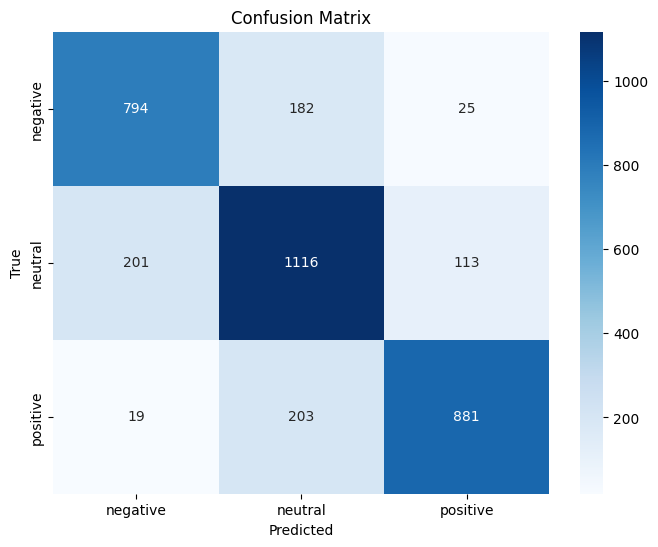

In [30]:
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()